
# Optimal power flow model in Julia

In [1]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using Dates
using TimeZones
using CairoMakie
using JuMP
import JSON
import MathOptInterface as MOI

using Revise
using OptHP

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.13.1
  [a93c6f00] DataFrames v1.7.0
  [87dc4568] HiGHS v1.13.0
  [682c06a0] JSON v0.21.4
  [4076af6c] JuMP v1.23.6
⌃ [b8f27783] MathOptInterface v1.35.1
  [2d871509] OptHP v1.0.0-DEV `OptHP`
  [295af30f] Revise v3.7.2
  [2913bbd2] StatsBase v0.34.4
  [f269a46b] TimeZones v1.20.0
  [ade2ca70] Dates
Info Packages marked with ⌃ have new versions available and may be upgradable.


## Load power / user data

In [2]:
network = CSV.read("data/network.csv", DataFrame)
network.R = network.R ./ Z_base
network.X = network.X ./ Z_base
network.Inom = network.Inom ./ I_base
first(network, 5)

Row,StartNode,EndNode,Length,cable,Inom,R,X
,Int64,Int64,Float64,String7,Float64,Float64,Float64
1,47,15,22.21,50Al,0.000288144,0.0269123,0.00356871
2,49,40,15.57,95Al,0.000422878,0.00941853,0.0024135
3,26,41,18.26,95Al,0.000422878,0.0110457,0.00283047
4,11,12,6.71,95Al,0.000422878,0.00405898,0.00104011
5,12,27,6.52,95Al,0.000422878,0.00394405,0.00101066


In [3]:
connections = CSV.read("data/user_connect.csv", DataFrame; delim=";")

# convert PV (str) to Float64
connections.PV = parse.(Float64, replace.(connections.PV, "," => "."))

first(connections, 5)

Row,Column1,Name,Node.ID,Node.Unom,Length,Type short,Connection value,load,PV,HP,Node
,Int64,Int64,Int64,Int64,String7,String15,String7,Int64,Float64,Int64,Int64
1,1,871694840006284337,46559968,230,"21,75",XLPE 4x6Cu,3x25 A,7000,4.0,1,50
2,2,871694840006288793,46563894,230,"2,22",XLPE 4x6Cu,3x25 A,7000,6.0,0,51
3,3,871694840006284108,11195660,230,"10,4",PVC 4x16Al,1x35 A,2000,2.2,0,52
4,4,871694840006284115,11195660,230,"10,4",PVC 4x16Al,1x35 A,500,2.2,0,53
5,5,871694840006284092,2573422,230,"7,33",PVC 4x16Al,1x35 A,2000,2.2,0,54


In [4]:
# define date to use for filtering
date = Date(2024, 2, 1)

# load data
path = "data/H14/H14_usage_return.csv"
loads = CSV.read(path, DataFrame)
loads.timestamp = DateTime.(loads.timestamp, "yyyy-mm-dd HH:MM:SS")
loads = loads[:, 2:3]

# we rescale usage_total_kW to usage_total_W to p.u.: 1E3 .* usage_total_kW / S_base
loads.usage_total_pu = 1E3 .* loads.usage_total_kW ./ S_base
select!(loads, Not(:usage_total_kW))

first(loads, 5)

Row,timestamp,usage_total_pu
,DateTime,Float64
1,2024-01-17T23:00:00,0.0
2,2024-01-17T23:15:00,0.0112
3,2024-01-17T23:30:00,0.0121333
4,2024-01-17T23:45:00,0.0146667
5,2024-01-18T00:00:00,0.0123556


## Read weather data

In [5]:
weather_df = CSV.read("data/weather/weather.csv", DataFrame)
select!(weather_df, Not([:interpolated]))
rename!(weather_df, Dict("P_solar" => "Φ_s", "T_ambient" => "T_a"))

dt_format = "yyyy-mm-ddTHH:MM:SS.sss+zzzz"
weather_df.timestamp = DateTime.(ZonedDateTime.(String.(weather_df.timestamp), dt_format))
weather_df = interpolate_data(weather_df, 15)

# select a particular day (Defined in date above)
# weather_df = weather_df[Date.(weather_df.timestamp) .== date, :]

# add electricity price [€/kWh]
weather_df.λ_e .= 0.21

# convert Φ_s from W to kW
weather_df.Φ_s .= weather_df.Φ_s ./ 1000

println("Weather data shape: ", size(weather_df))
first(weather_df, 5)

Interpolating columns: [:Φ_s, :T_a]
Weather data shape: (27169, 4)


Row,timestamp,Φ_s,T_a,λ_e
,DateTime,Float64,Float64,Float64
1,2023-09-01T00:00:00,0.0,9.5,0.21
2,2023-09-01T00:15:00,0.0,9.45,0.21
3,2023-09-01T00:30:00,0.0,9.6,0.21
4,2023-09-01T00:45:00,0.0,9.5,0.21
5,2023-09-01T01:00:00,0.0,9.6,0.21


## Merge data and display

In [6]:
df_full = innerjoin(weather_df, loads, on = :timestamp);

In [7]:
# select a particular day (Defined by date)
date = Date(2024, 2, 4)

df = df_full[Date.(df_full.timestamp) .== date, :]

first(df, 5)

Row,timestamp,Φ_s,T_a,λ_e,usage_total_pu
,DateTime,Float64,Float64,Float64,Float64
1,2024-02-04T00:00:00,0.0,8.5,0.21,0.000844444
2,2024-02-04T00:15:00,0.0,8.3,0.21,0.000711111
3,2024-02-04T00:30:00,0.0,8.0,0.21,0.000755556
4,2024-02-04T00:45:00,0.0,7.95,0.21,0.000711111
5,2024-02-04T01:00:00,0.0,8.0,0.21,0.00111111


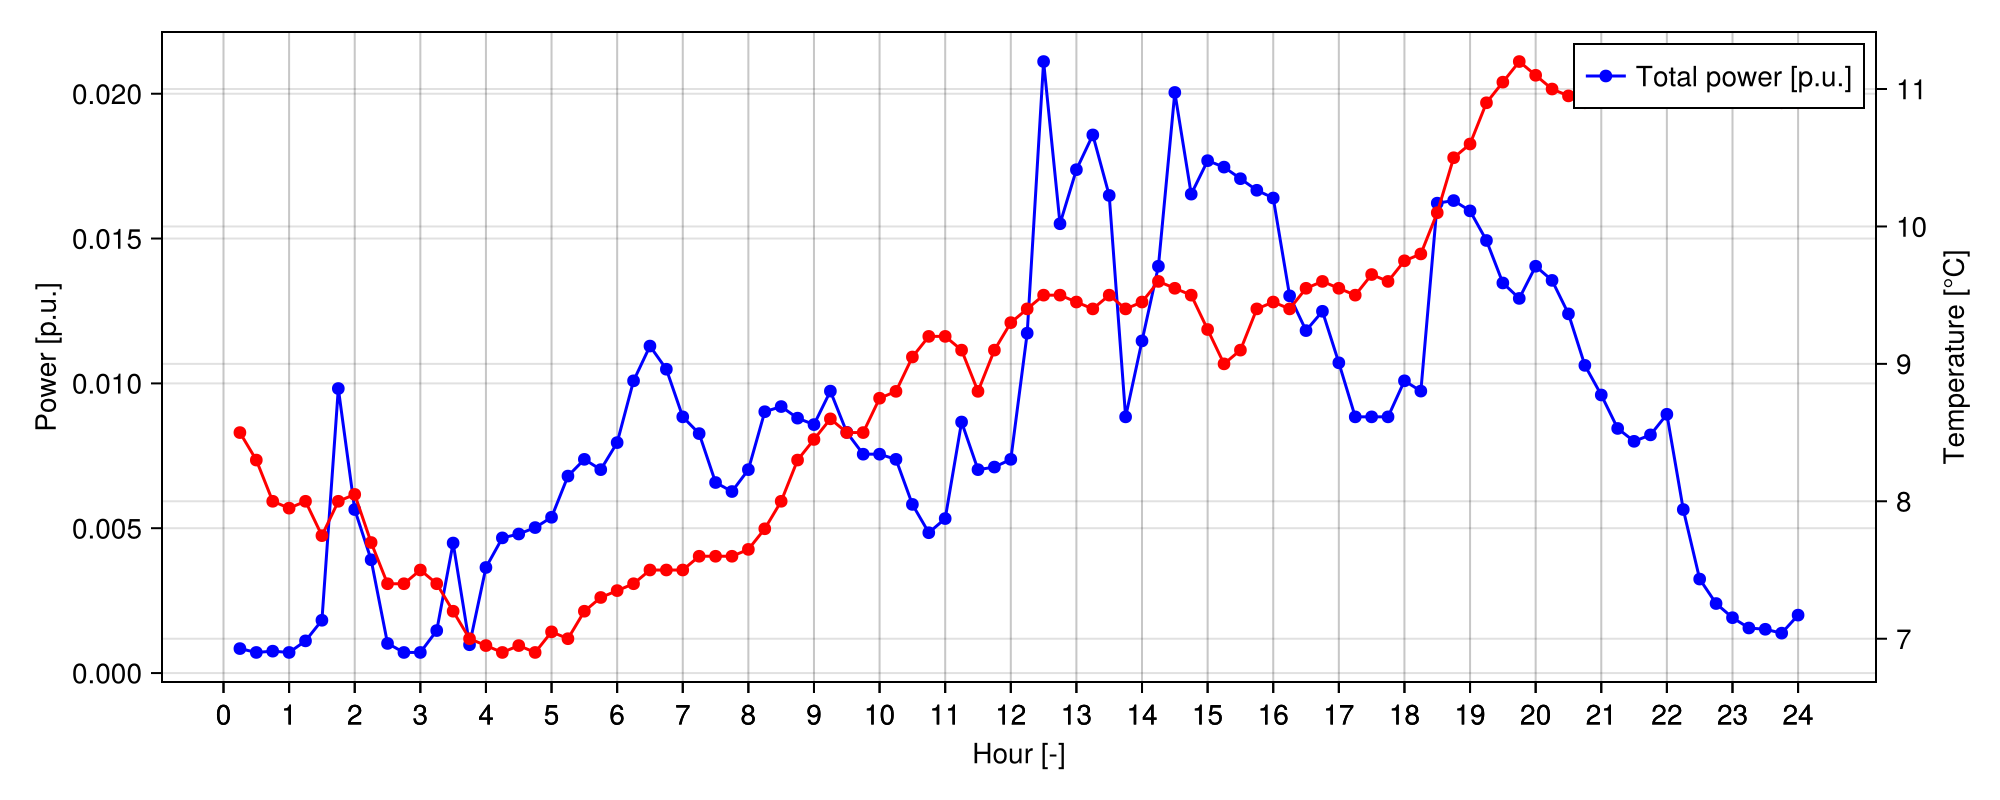

In [8]:
# plot user power data
fig = Figure(; size = (1000, 400))

ax_power = Axis(fig[1, 1], xlabel="Hour [-]", ylabel="Power [p.u.]", xticks=(0:4:96, string.(0:1:24)))
ax_temp = Axis(fig[1, 1], ylabel="Temperature [°C]", xticks=(0:4:96, string.(0:1:24)), yaxisposition = :right)

scatterlines!(ax_power, df.usage_total_pu, label="Total power [p.u.]", color=:blue)
scatterlines!(ax_temp, df.T_a, label="Temperature", color=:red)
axislegend(ax_power)
fig

## Load state-space matrices

In [9]:
id = "H14"

A_d = Matrix(CSV.read("data/$(id)/$(id)_15min_A_exact.csv", DataFrame))
B_d = Matrix(CSV.read("data/$(id)/$(id)_15min_B_exact.csv", DataFrame))

H14_meta = Dict(
    "A" => A_d,
    "B" => B_d
)

meta = Dict(
    "H14" => H14_meta
)

Dict{String, Dict{String, Matrix{Float64}}} with 1 entry:
  "H14" => Dict("B"=>[0.00663784 0.00224598 0.166439; 9.37536e-5 2.65051e-6 0.0…

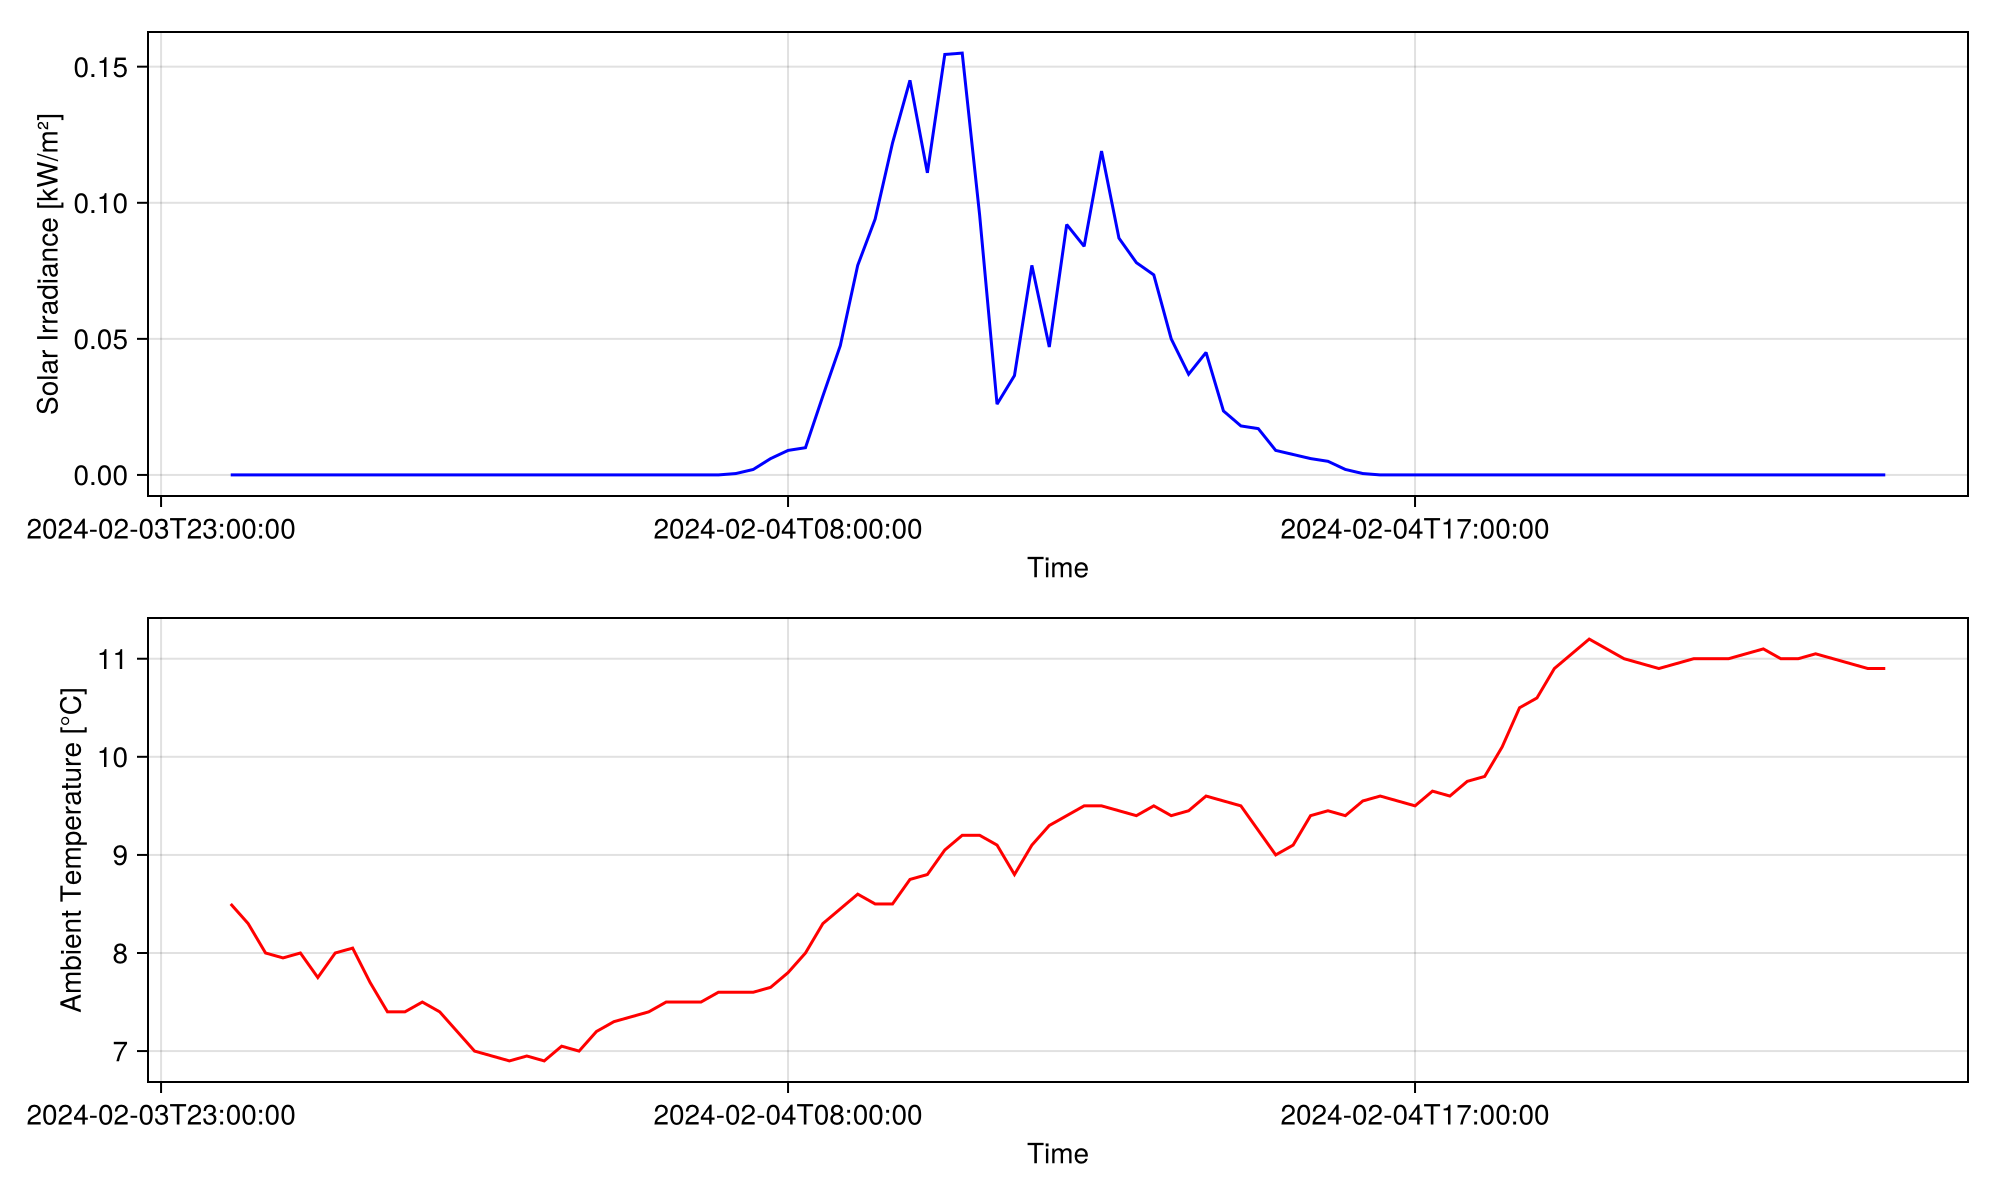

In [10]:
# plot the weather data
fig = Figure(; size = (1000, 600))

ax1 = Axis(fig[1, 1], xlabel="Time", ylabel="Solar Irradiance [kW/m²]")
ax2 = Axis(fig[2, 1], xlabel="Time", ylabel="Ambient Temperature [°C]")

lines!(ax1, DateTime.(df.timestamp), df.Φ_s, color=:blue)
lines!(ax2, DateTime.(df.timestamp), df.T_a, color=:red)
fig

## Grid model with test data

In [11]:
function plot_line_currents(model::Model, lines::Vector{Tuple{Int, Int}}=[(34, 0), (2, 74)])
    fig = Figure(; size = (1000, 600))

    I_line = value.(model[:I_line])
    for (idx,(i,j)) in enumerate(lines)
        ax = Axis(fig[idx, 1], xlabel = "Time [hours]", 
            ylabel = "Current [A]", 
            title = "($i -> $j)",
            xticks = (1:4:97, string.(0:1:24))
        )
        scatterlines!(ax, Vector(I_line[(i,j),:]), color = :blue, label = "$i->$j", linewidth = 2)
    end

    fig
end

function plot_pq(model::Model, bus::Int; S_base::Float64=-1.0)
    fig = Figure(; size = (1000, 300))

    # index of slack bus (transformer)
    # SB = argmin(value.(model[:P]).axes[2])
    P_trafo = Matrix(value.(model[:P]))[bus,:]
    Q_trafo = Matrix(value.(model[:Q]))[bus,:]
    y_txt = "Power [p.u.]"

    if S_base > 0
        P_trafo = P_trafo .* S_base .* 1E-3
        Q_trafo = Q_trafo .* S_base .* 1E-3
        y_txt = "Power [kW]"
    end

    ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
        title = "Power flow",
        # ylabel = ylabel,
        ylabel = y_txt,
        xticks = (1:4:97, string.(0:1:24))
    )

    # lines!(ax, sol[:P], color = :blue, label = "Transformer", linestyle = :so
    scatterlines!(ax, P_trafo, color = :blue, label = "P trafo", linewidth = 2)
    scatterlines!(ax, Q_trafo, color = :red, label = "Q trafo", linewidth = 2)
    axislegend(ax, position = :lt)

    # display
    fig
end


plot_pq (generic function with 1 method)

In [12]:
# # test network with 4 buses 
# #       0   (slack)
# #       |
# #       1   (junction)
# #      / \
# #     2   3 (loads)

# network_test = DataFrame(
#     StartNode = [0, 1, 1],
#     EndNode = [1, 2, 3],
#     Length = [1.0, 1.0, 1.0],
#     Inom = [0.1, 0.1, 0.1],
#     R = [0.1, 0.1, 0.1],
#     X = [0.2, 0.2, 0.2]
# )

# # correct R, X using Z_base
# network_test.R = network_test.R ./ Z_base
# network_test.X = network_test.X ./ Z_base

# # grid connections
# connections_test = DataFrame(
#     HP = [0, 0],
#     Node = [2, 3]
# )

# # loads real 
# N = 96
# df_test = DataFrame(
#     # Symbol("usage_total_pu") => collect(range(0.1, stop = 0.2, length = N)),
#     Symbol("usage_total_pu") => 0.1*ones(N),
# )
# println("Z_base: ", Z_base, " S_base: ", S_base, " V_base: ", V_base, " I_base: ", I_base)
# first(df_test, 5)

In [13]:
# model = GEC(network=network_test, 
#             connections=connections_test, 
#             df=df_test,
#             meta = meta,
#             silent=false,
#             T=1:N
# )

In [14]:
# plot_line_currents(model, [(0,1), (1,2), (1,3)])

In [15]:
# plot_pq(model, 1)

## Load PPD median data

In [16]:
# data\PPD\PPD_quantiles.csv
medians = CSV.read("data/PPD/PPD_quantiles.csv", DataFrame)

Row,Ta,min,max,Q1,Q2,Q3
,Int64,Float64,Float64,Float64,Float64,Float64
1,15,5.0,57.6,14.2,28.1,40.8
2,16,5.0,53.7,11.5,23.2,35.0
3,17,5.0,48.6,9.2,18.4,29.1
4,18,5.0,43.1,7.7,14.4,23.5
5,19,5.0,37.7,6.8,11.2,18.4
6,20,5.0,32.4,6.1,9.1,14.5
7,21,5.0,26.6,5.7,7.7,11.7
8,22,5.0,21.7,5.4,6.8,10.0
9,23,5.0,18.6,5.3,6.4,9.1


## Full model

In [17]:
T=1:96

1:96

In [18]:
model = GEC(network=network, 
            connections=connections,
            df=df,
            medians=medians,
            meta = meta,
            silent=false,
            T=T
)

Set parameter Username
Set parameter LicenseID to value 2599292
Academic license - for non-commercial use only - expires 2025-12-13
Set parameter BarHomogeneous to value 1
Set parameter Presolve to value 0
Set parameter BarHomogeneous to value 1
Set parameter Presolve to value 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 5950X 16-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
BarHomogeneous  1
Presolve  0

Optimize a model with 87036 rows, 94368 columns and 250056 nonzeros
Model fingerprint: 0xdb9089f0
Model has 8256 quadratic constraints
Variable types: 92064 continuous, 2304 integer (2304 binary)
Coefficient statistics:
  Matrix range     [4e-07, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [8e-01, 3e+01]
  RHS range        [6e-04, 9e+01]
Variable types: 117408 continuou

A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 61344
├ num_constraints: 90720
│ ├ AffExpr in MOI.EqualTo{Float64}: 42492
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8064
│ ├ AffExpr in MOI.LessThan{Float64}: 3456
│ ├ Vector{AffExpr} in MOI.SecondOrderCone: 8256
│ ├ VariableRef in MOI.EqualTo{Float64}: 1188
│ ├ VariableRef in MOI.GreaterThan{Float64}: 16608
│ ├ VariableRef in MOI.LessThan{Float64}: 8352
│ └ VariableRef in MOI.ZeroOne: 2304
└ Names registered in the model
  └ :ConicOPF, :I_line, :J_c_heat, :J_gen, :J_loss, :J_ppd, :P, :PPD, :P_HP, :P_line, :Q, :Q_HP, :Q_line, :QvsP, :ReactiveBaseLoad, :ReactiveHPBaseLoad, :ReactivePowerBalance, :RealBaseLoad, :RealHPBaseLoad, :RealPowerBalance, :Te, :Transmission, :VoltageDrop, :g, :u, :v, :z_CV, :z_HP, :ΔT, :Φ_CV, :Φ_HP, :Φ_h, :η_COP

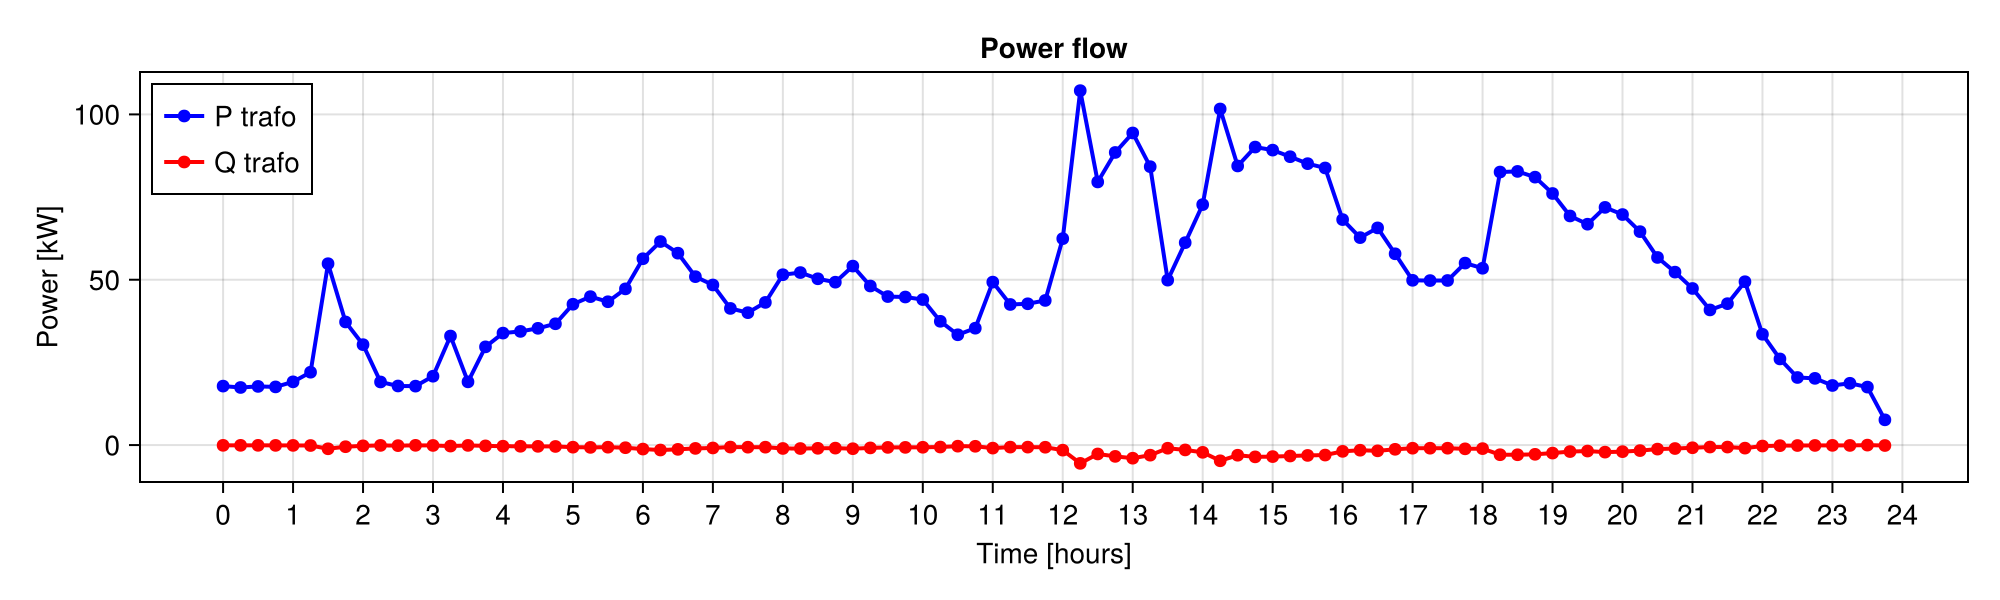

In [19]:
plot_pq(model, 55, S_base=S_base)

## Plot heat pump consumption profile

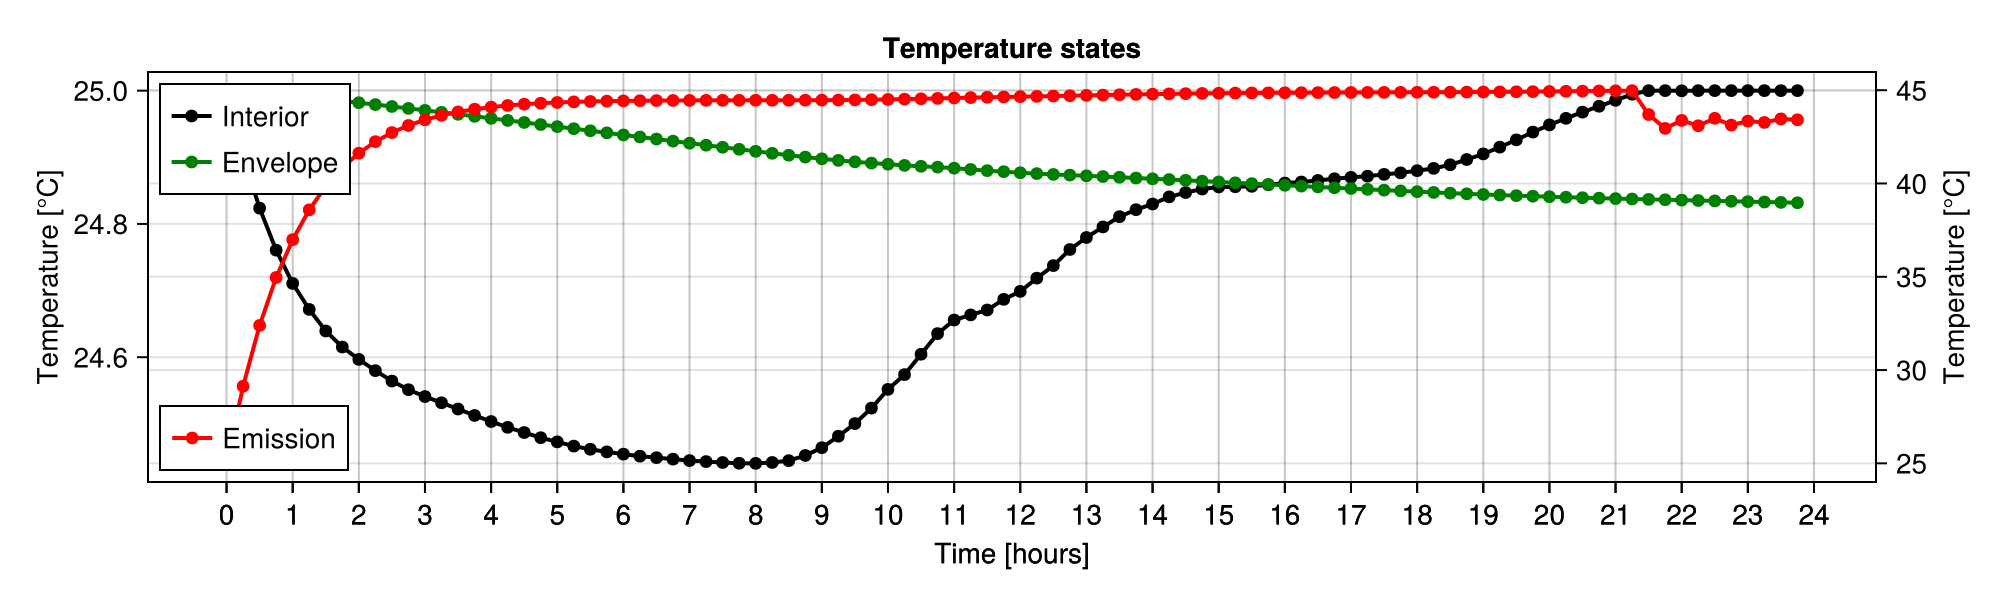

In [20]:
# value.(model[:Te])

function plot_temperature_states(model::Model, bus::Int)
    fig = Figure(; size = (1000, 300))

    # index of slack bus (transformer)
    Ti = Vector(value.(model[:Te])[bus, :, :i])
    Te = Vector(value.(model[:Te])[bus, :, :e])
    Th = Vector(value.(model[:Te])[bus, :, :h])

    ax_int = Axis(fig[1, 1], xlabel = "Time [hours]", 
        title = "Temperature states",
        ylabel = "Temperature [°C]",
        xticks = (1:4:97, string.(0:1:24))
    )

    ax_emi = Axis(fig[1, 1], xlabel = "Time [hours]", 
        title = "Temperature states",
        ylabel = "Temperature [°C]",
        xticks = (1:4:97, string.(0:1:24)), 
        yaxisposition = :right
    )

    scatterlines!(ax_int, Ti, color = :black, label = "Interior", linewidth = 2)
    scatterlines!(ax_int, Te, color = :green, label = "Envelope", linewidth = 2)
    scatterlines!(ax_emi, Th, color = :red, label = "Emission", linewidth = 2)
    axislegend(ax_int, position = :lt)
    axislegend(ax_emi, position = :lb)

    # display
    fig
end

function plot_hybrid_hp_power(model::Model, bus::Int)
    fig = Figure(; size = (1000, 300))

    # index of slack bus (transformer)
    P_hp = Vector(value.(model[:P_HP])[bus, :]) * S_base * 1E-3
    Q_hp = Vector(value.(model[:Q_HP])[bus, :]) * S_base * 1E-3
    Φ_hp = Vector(value.(model[:Φ_HP])[bus, :])
    Φ_cv = Vector(value.(model[:Φ_CV])[bus, :])

    ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
        title = "Heat pump power",
        ylabel = "Power [kW]",
        xticks = (1:4:97, string.(0:1:24))
    )

    scatterlines!(ax, P_hp, color = :blue, label = "P hp", linewidth = 2)
    scatterlines!(ax, Q_hp, color = :red, label = "Q hp", linewidth = 2)
    scatterlines!(ax, Φ_hp, color = :orange, label = "Φ hp", linewidth = 2)
    scatterlines!(ax, Φ_cv, color = :green, label = "Φ cv", linewidth = 2)
    axislegend(ax, position = :lt)

    # display
    fig
end

plot_temperature_states(model, 64)

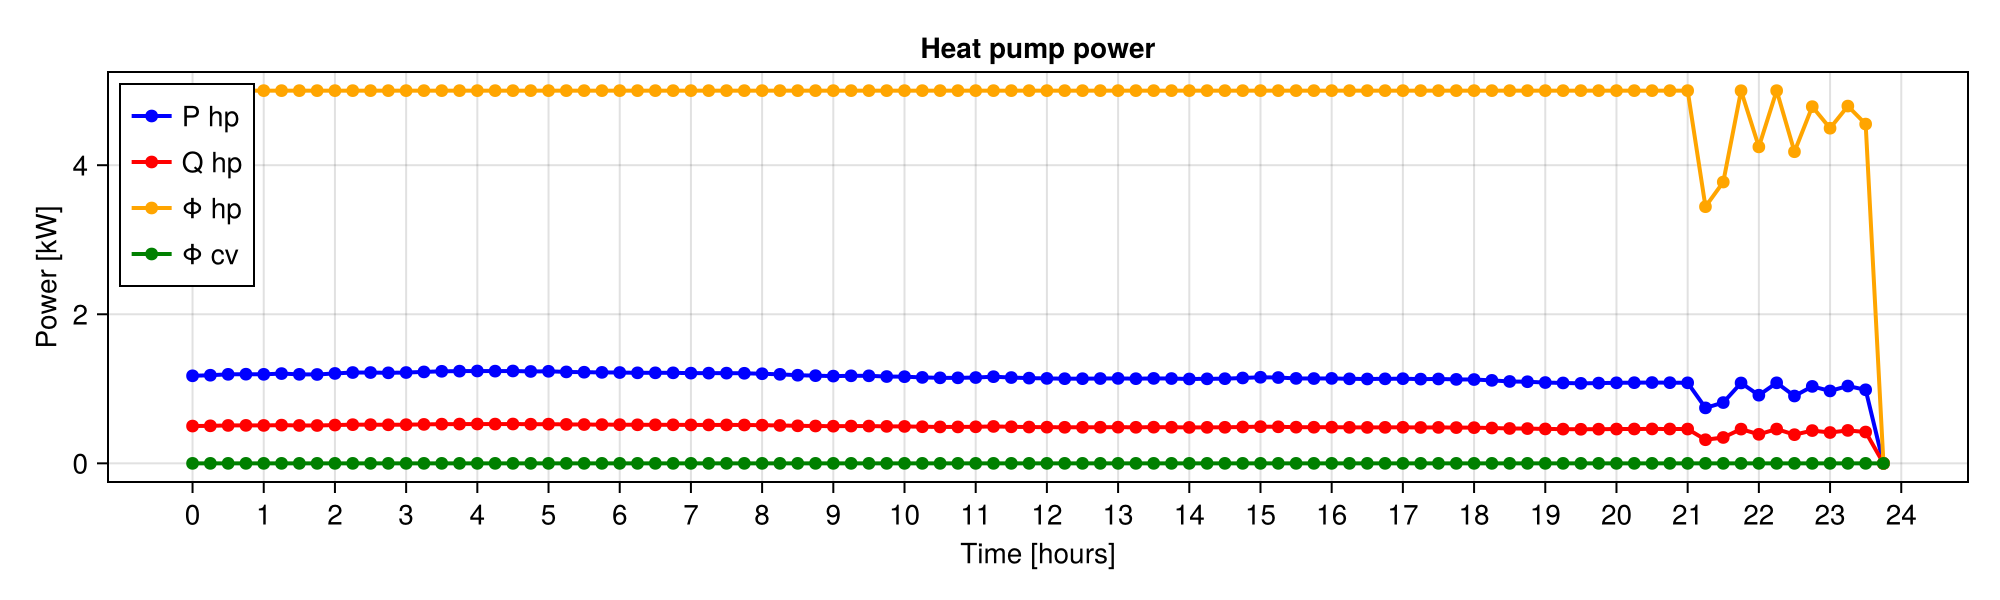

In [21]:
plot_hybrid_hp_power(model, 64)

## Plot PPD vs interior temperature

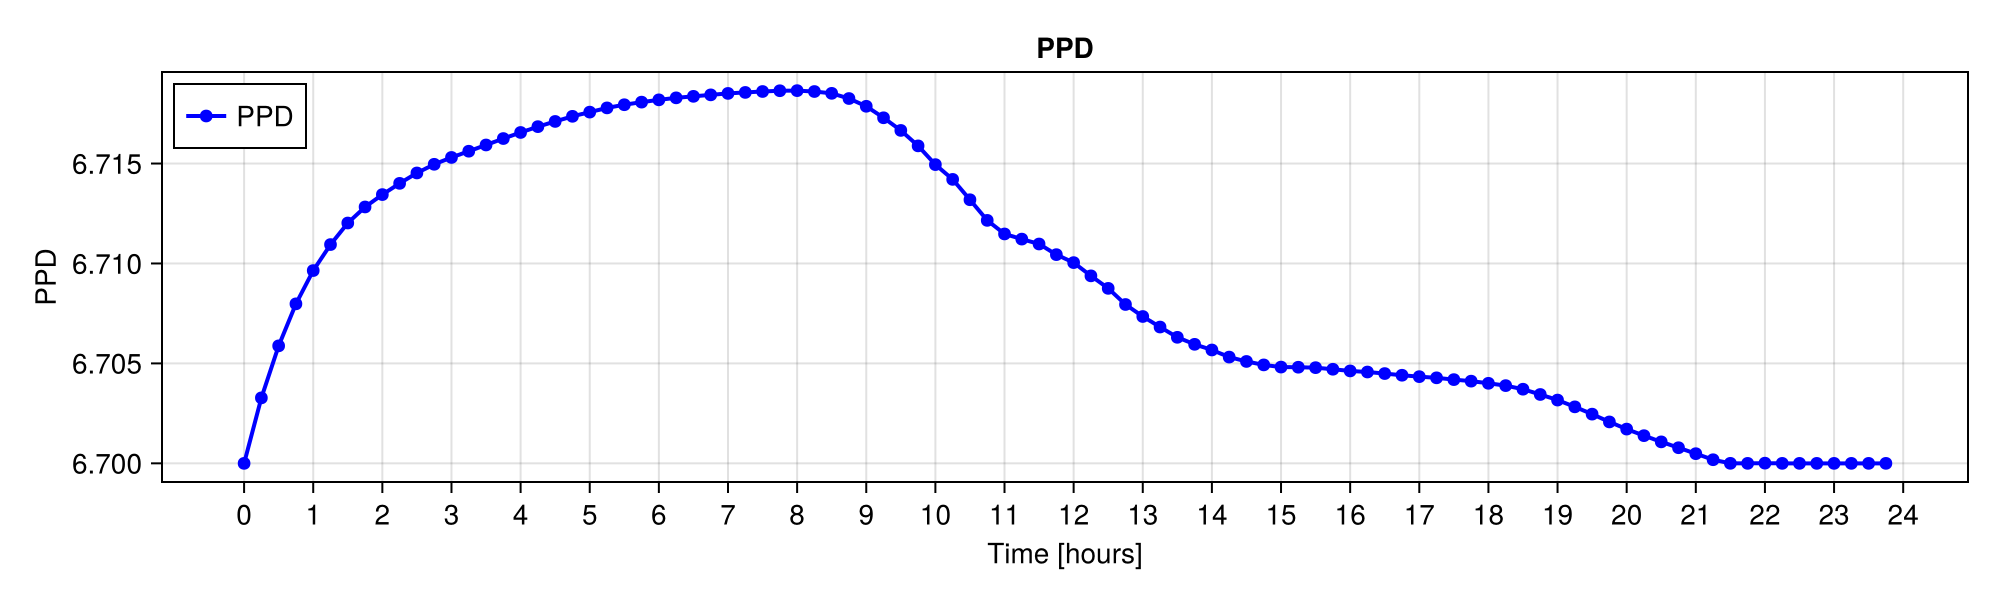

In [25]:
function plot_ppd(model::Model, bus::Int)
    fig = Figure(; size = (1000, 300))

    # ppd variable
    PPD = Vector(value.(model[:PPD])[bus, :])

    ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
        title = "PPD",
        ylabel = "PPD",
        xticks = (1:4:97, string.(0:1:24))
    )

    scatterlines!(ax, PPD, color = :blue, label = "PPD", linewidth = 2)
    axislegend(ax, position = :lt)

    # display
    fig
end

plot_ppd(model, 64)